# <b> 0. IMPORTING LIBRARIES

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

# <b> 1. CREATING PATHS TO DIRECTORIES

In [2]:
#files path in a dictionary
paths = dict()
# Linux pc
paths['main'] = '/home/javi/Desktop/Python/MNIST_OD'
paths['dataset'] = os.path.join(paths['main'], 'MNIST_dataset')
paths['train_data'] = os.path.join(paths['dataset'], 'train')
paths['test_data'] = os.path.join(paths['dataset'], 'test')
# Windows pc
# paths['main'] = os.path.normcase('D:\Javi\Python\MNIST_OD')#.replace('\\','/'))
# paths['dataset'] = os.path.join(paths['main'], 'MNIST_dataset'))
# paths['train_data'] = os.path.join(paths['dataset'], 'train')
# paths['test_data'] = os.path.join(paths['dataset'], 'test')
# paths['test_img'] = os.path.join(paths['test_data'], 'test')

In [ ]:
def pascal_voc_to_dict(filepath):
    """Function to get all the objects from the annotation XML file."""
    with tf.io.gfile.GFile(annon_filepath, "r") as f:
        root = xml.etree.ElementTree.parse(f).getroot()

        # Disable pytype to avoid attribute-error due to find returning
        # Optional[Element]
        # pytype: disable=attribute-error
        size = root.find("size")
        width = float(size.find("width").text)
        height = float(size.find("height").text)
        filePath = size.find("filename").text

        for obj in root.findall("object"):
            # Get object's label name.
            label = obj.find("name").text.lower()
            # Get objects' pose name.
            pose = obj.find("pose").text.lower()
            is_truncated = obj.find("truncated").text == "1"
            is_difficult = obj.find("difficult").text == "1"
            bndbox = obj.find("bndbox")
            xmax = float(bndbox.find("xmax").text)
            xmin = float(bndbox.find("xmin").text)
            ymax = float(bndbox.find("ymax").text)
            ymin = float(bndbox.find("ymin").text)
            yield {
                      "label": label,
                      # "pose": pose,
                      "bbox": tfds.features.BBox(
                          ymin / height, xmin / width, ymax / height, xmax / width
                      ),
                      # "is_truncated": is_truncated,
                      # "is_difficult": is_difficult,
                    }

In [35]:
# files = os.listdir(paths['train_data'])
def map_images_from_path(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)
    return img

data = tf.data.Dataset.list_files(paths['train_data']+'/*.jpg')
data = data.map(map_images_from_path)


In [24]:
file_path = data.as_numpy_iterator().next()
#img = tf.io.read_file(file_path)

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [41]:
for i in data.take(1):
    print(i.numpy())

[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]


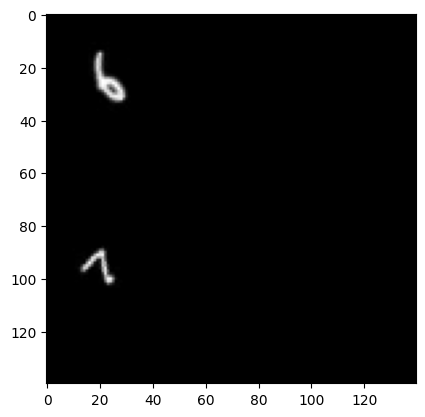

In [33]:
img = tf.io.read_file(file_path)
plt.imshow(tf.io.decode_jpeg(img, channels=1).numpy(),cmap='gray')

In [46]:
tf.keras.datasets.features.BBox(1,2,3,4)

AttributeError: module 'keras.api._v2.keras.datasets' has no attribute 'features'

In [47]:
import tensorflow_datasets as tfds

ModuleNotFoundError: No module named 'tensorflow_datasets'